In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pickle
from tensorflow.keras.models import load_model
import random
import time  # Import the time module



In [2]:
# Setting random seed
np.random.seed(2)

In [3]:
# Input/Prediction data
#test_data = pd.read_csv('sim_compendia_test/sims_compendium_test_vol_0.1.csv')
test_data = pd.read_csv('sim_compendia_test/tz_region_data_16to22_dist.csv')
#test_data = data[data['run']>150]

In [4]:
# Log transform function
def log_transform(data):
    return np.log(data)#1p

# Inverse log transform function
def inverse_log_transform(data):
   return np.exp(data)

In [5]:
# Window size used in the original model
window_size = 10

In [6]:
# Importing sequence function
from sequence_creator import create_sequences

In [7]:
# Loading trained model
model = load_model('EIR_LSTM_Results/lstm_model_shuffled_random_vol_random_init_EIR_3500_W10.keras')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\Users\oibrahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


C:\Users\oibrahim\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


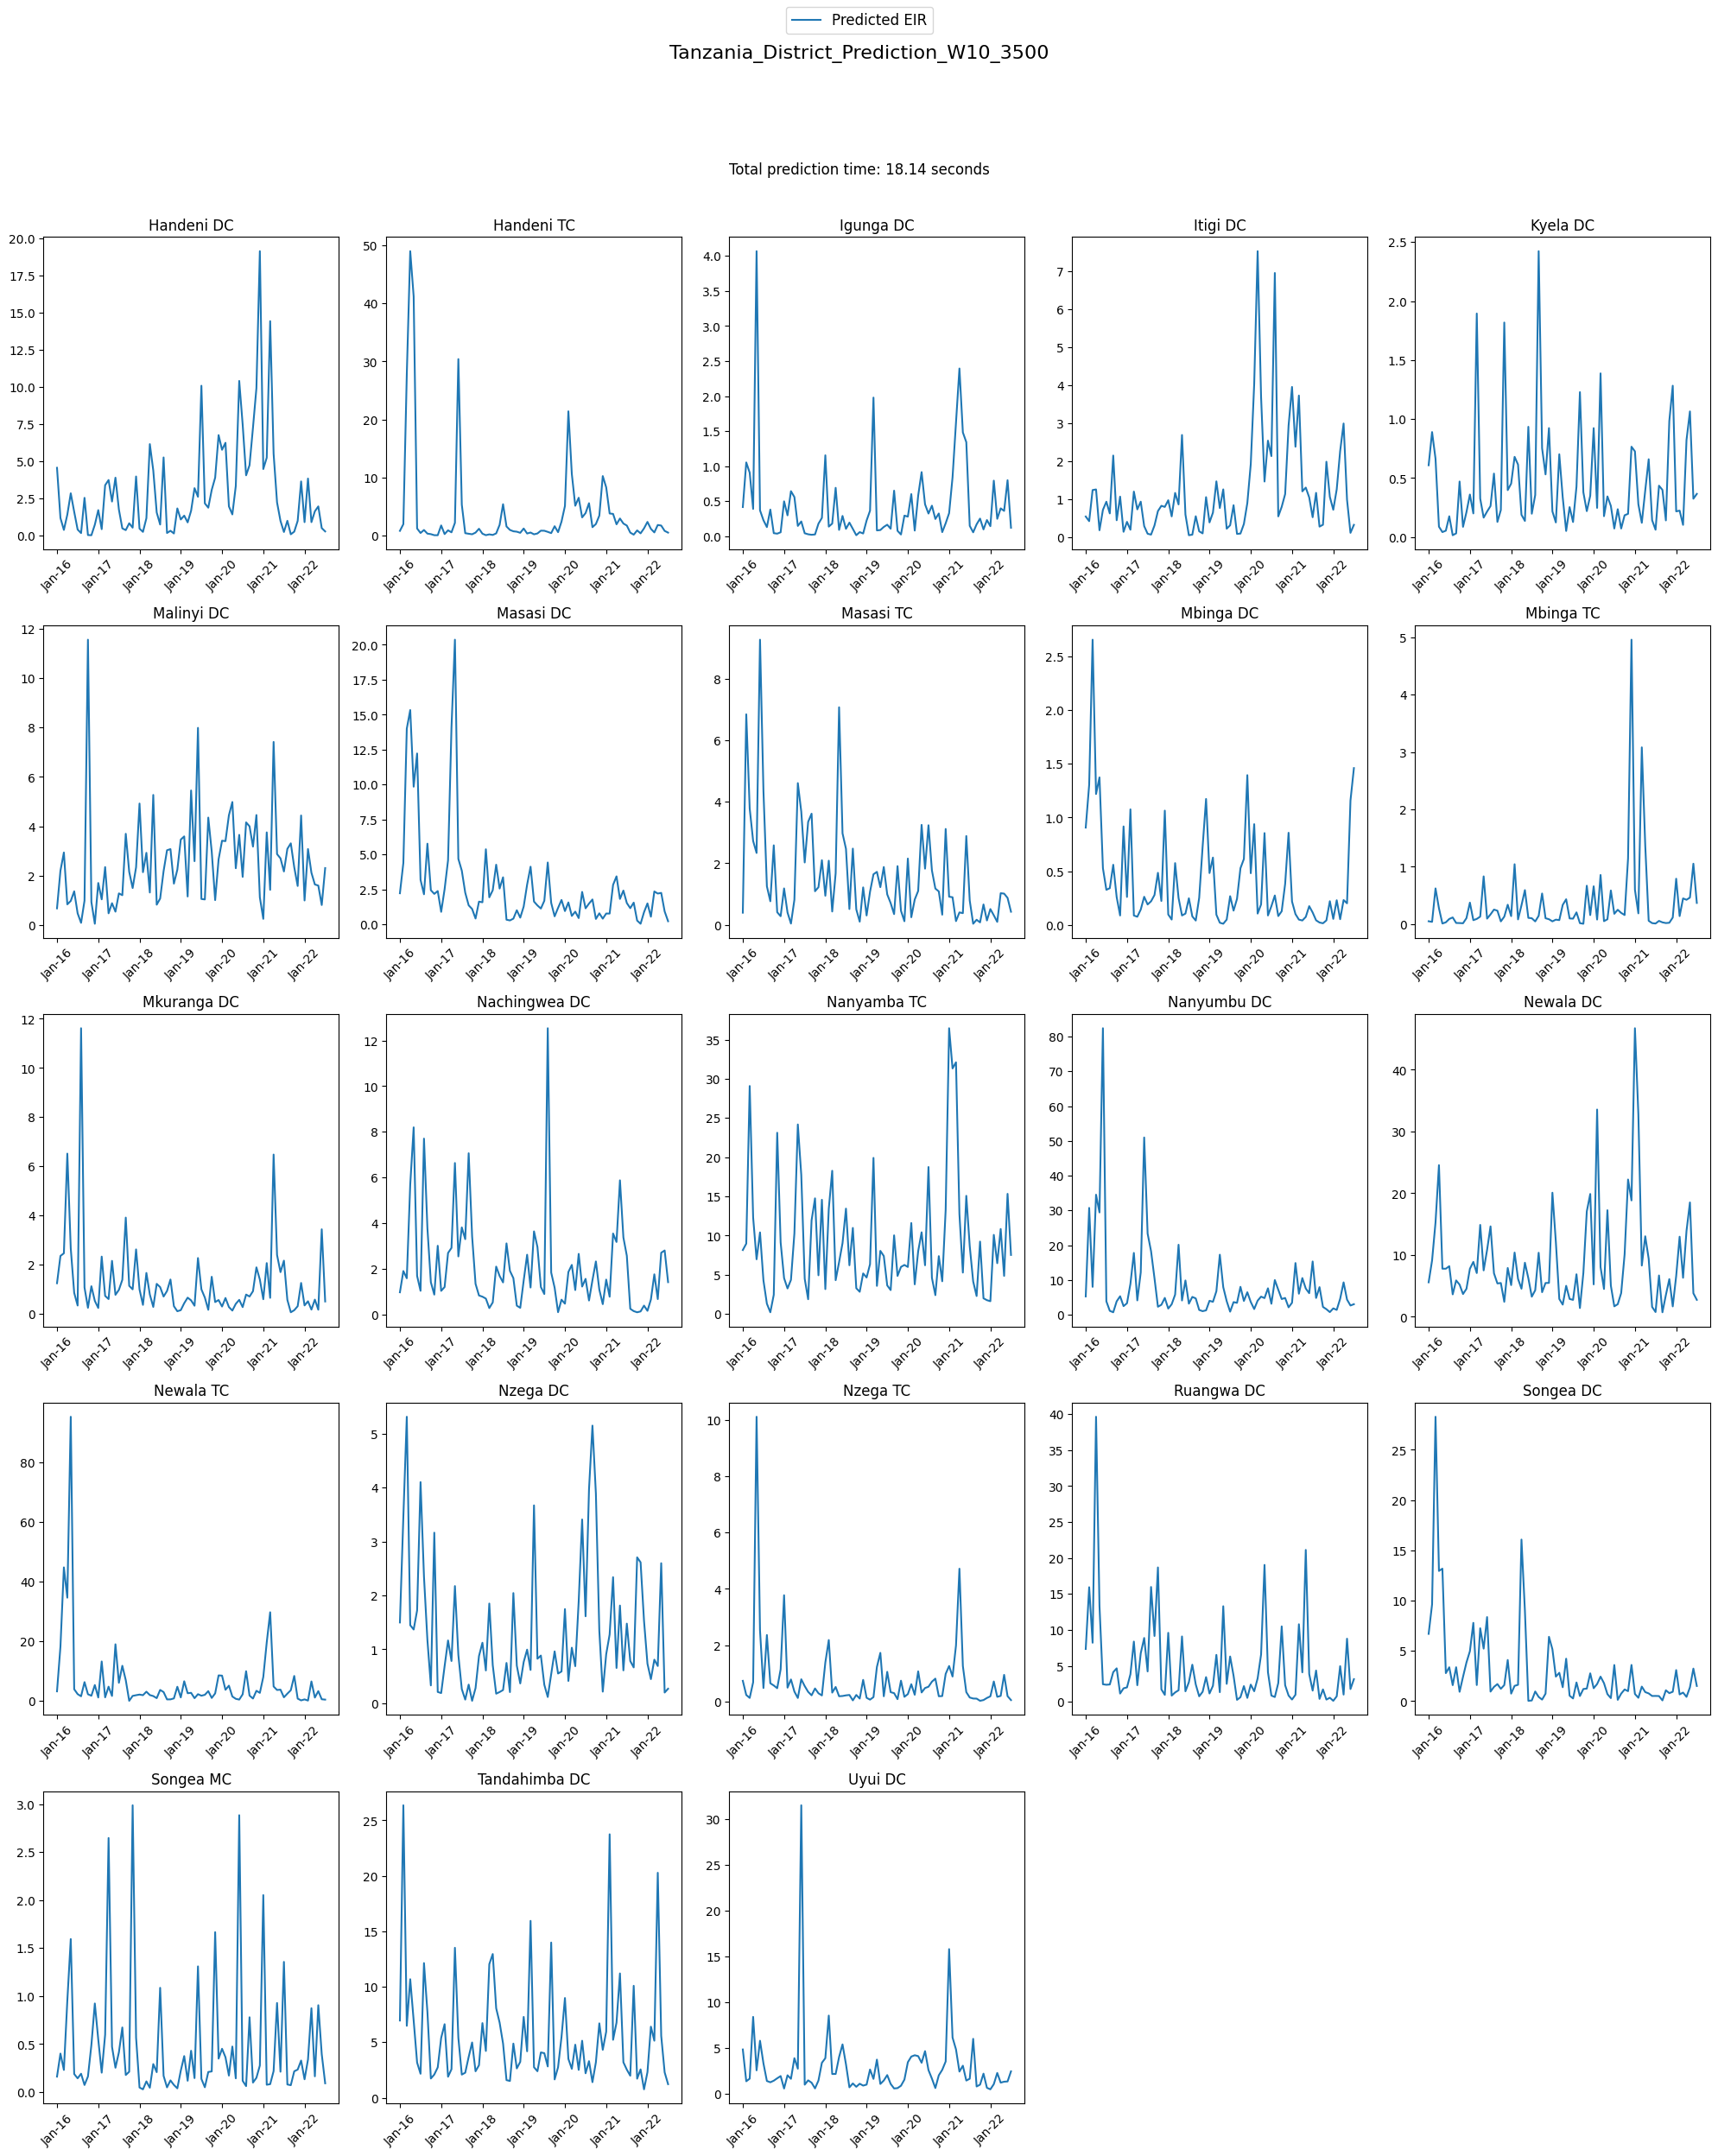

In [10]:
# Initialize a list to store the time taken for predictions
prediction_times = []

unique_runs = test_data['District'].unique()
n_regions = len(unique_runs)

# Determine the number of rows and columns for a nearly square grid
n_cols = int(np.ceil(np.sqrt(n_regions)))
n_rows = int(np.ceil(n_regions / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axs = axs.flatten()  # Flattening the 2D array of axes into a 1D array for easy indexing

fig.suptitle('Tanzania_District_Prediction_W10_3500', fontsize=16)
plt.subplots_adjust(top=0.92)  #space between suptitle and subplots

# Storing handles and labels for the universal legend
handles = []
labels = []

# Starting timer
total_start_time = time.time()

# A new column to store predicted EIR values
test_data['Predicted_EIR'] = np.nan  # Initialize with NaN values

for i, District in enumerate(unique_runs):
    run_data = test_data[test_data['District'] == District].copy()

    # timer for unique region prediction
    region_start_time = time.time()
    
    # Apply the log transform to both 'prev_true' and 'EIR_true'
    scaled_run_data = run_data[['prev_true', 'EIR_true']].apply(log_transform)
    
    # Create sequences using both 'prev_true' and 'EIR_true'
    X_test_scaled, y_test = create_sequences(scaled_run_data, window_size)
    X_test, _ = create_sequences(run_data[['prev_true', 'EIR_true']], window_size)

    # Predict and inverse transform the predictions
    test_predictions_scaled = model.predict(X_test_scaled)
    test_predictions = inverse_log_transform(test_predictions_scaled).flatten()

    # Adjust the 'months' array to match the length of the predicted sequences
    start_index = 0  # Change from window_size to 0 to include all predictions
    end_index = start_index + len(test_predictions)  # End at the length of predictions

    # Create a months array that starts at the beginning of the relevant data
    months = run_data['month'].iloc[start_index:end_index].values

    # Plot predicted EIR_true
    line, = axs[i].plot(months, test_predictions, label='Predicted EIR')
    axs[i].set_title(f'{District}')

    # Store the handle and label for the universal legend
    handles.append(line)
    labels.append('Predicted EIR')  

    # Set x-ticks to show labels at intervals (e.g., every 6 months)
    axs[i].set_xticks(months[::12])
    axs[i].set_xticklabels(months[::12], rotation=45)  # Rotate labels for better readability

    # Save predictions in the 'Predicted_EIR_true' column in the original DataFrame
    # Assign predicted values to all indices, including the padded ones
    test_data.loc[run_data.index[start_index:end_index], 'Predicted_EIR'] = test_predictions

    # Stop the timer for this region and calculate the time taken
    region_end_time = time.time()
    region_time = region_end_time - region_start_time
    prediction_times.append(region_time)

# Remove any unused subplots
for j in range(n_regions, len(axs)):
    fig.delaxes(axs[j])

# Calculate the total time taken for all predictions
total_time = time.time() - total_start_time

# Display cumulative time in seconds at the bottom of the plot
plt.figtext(0.5, 0.92, f'Total prediction time: {total_time:.2f} seconds', ha='center', fontsize=12)

# Legend Configuration
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=1, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('plots/Tanzania_District_Prediction_W10_3500).png')
plt.show()

# Save the updated DataFrame with predicted EIR values
test_data.to_csv('src/Tanzania_District_Prediction_W10_3500.csv', index=False)


In [9]:
abc

NameError: name 'abc' is not defined

In [ ]:
# Initialize a list to store the time taken for predictions
prediction_times = []

# Your existing code for plotting
unique_runs = test_data['region'].unique()
n_regions = len(unique_runs)

# Determine the number of rows and columns for a nearly square grid
n_cols = int(np.ceil(np.sqrt(n_regions)))
n_rows = int(np.ceil(n_regions / n_cols))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axs = axs.flatten()  # Flatten the 2D array of axes into a 1D array for easy indexing

fig.suptitle('Predicted EIR_W10_3500run', fontsize=16)
plt.subplots_adjust(top=0.92)  # Reduce space between suptitle and subplots

# Store handles and labels for the universal legend
handles = []
labels = []

# Start the overall timer
total_start_time = time.time()

for i, region in enumerate(unique_runs):
    run_data = test_data[test_data['region'] == region]

    # Start the timer for this region
    region_start_time = time.time()
    
    # Apply the log transform to both 'prev_true' and 'EIR_true'
    scaled_run_data = run_data[['prev_true', 'EIR_true']].apply(log_transform)
    
    # Create sequences using both 'prev_true' and 'EIR_true'
    X_test_scaled, y_test = create_sequences(scaled_run_data, window_size)
    X_test, _ = create_sequences(run_data[['prev_true', 'EIR_true']], window_size)

    test_predictions_scaled = model.predict(X_test_scaled)
    test_predictions = inverse_log_transform(test_predictions_scaled).flatten()

    # Adjust the 'months' array to match the length of the predicted sequences
    start_index = window_size  # Start at window_size to skip initial padding
    end_index = start_index + len(test_predictions)  # End at the length of predictions

    # Create a months array that starts at the beginning of the relevant data
    months = run_data['month'].iloc[0:end_index - window_size].values

    # Plot predicted EIR_true
    line, = axs[i].plot(months, test_predictions, label='Predicted EIR_true')
    axs[i].set_title(f'{region}')

    # Store the handle and label for the universal legend
    handles.append(line)
    labels.append('Predicted EIR_true')  # Use the same label for all regions

    # Set x-ticks to show labels at intervals (e.g., every 6 months)
    axs[i].set_xticks(months[::12])
    axs[i].set_xticklabels(months[::12], rotation=45)  # Rotate labels for better readability

    # Stop the timer for this region and calculate the time taken
    region_end_time = time.time()
    region_time = region_end_time - region_start_time
    prediction_times.append(region_time)

# Remove any unused subplots
for j in range(n_regions, len(axs)):
    fig.delaxes(axs[j])

# Calculate the total time taken for all predictions
total_time = time.time() - total_start_time

# Display cumulative time in seconds at the bottom of the plot
plt.figtext(0.5, 0.92, f'Total prediction time: {total_time:.2f} seconds', ha='center', fontsize=12)

# Legend Configuration
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=1, fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('EIR_LSTM_Results/Tanzania Prediction_W10_3500.png')
plt.show()


In [ ]:
a

In [ ]:
# Initialize an empty DataFrame to store the differences
diff_df = pd.DataFrame(columns=['run', 'true_EIR', 'predicted_EIR', 'difference'])

unique_runs = test_data['run'].unique()
fig, axs = plt.subplots(len(unique_runs)//5 + 1, 5, figsize=(20, (len(unique_runs)//5 + 1) * 4))
axs = axs.flatten()
fig.suptitle('True vs Predicted Volatility_1.0', fontsize=16)

for i, run in enumerate(unique_runs):
    run_data = test_data[test_data['run'] == run]
    scaled_run_data = run_data[['prev_true','EIR_true']].apply(log_transform)
    X_test_scaled, y_test_scaled = create_sequences(scaled_run_data, window_size)  # Creating Sequence for unique test run in scaled test
    X_test, y_test = create_sequences(run_data, window_size)   # Creating Sequence for unique test run in actual test

    test_predictions_scaled = model.predict(X_test_scaled)
    test_predictions = inverse_log_transform(test_predictions_scaled)

    # Calculate the difference between true and predicted values
    differences = y_test.flatten() - test_predictions.flatten()
    
    # Create a DataFrame for the current run
    run_diff_df = pd.DataFrame({
        'run': run,
        'true_EIR': y_test.flatten(),
        'predicted_EIR': test_predictions.flatten(),
        'difference': differences
    })
    
    # Append to the main DataFrame
    diff_df = pd.concat([diff_df, run_diff_df], ignore_index=True)

    # Calculating performance metrics
    mse = mean_squared_error(y_test, test_predictions)
    r2 = r2_score(y_test, test_predictions)
    mae = mean_absolute_error(y_test, test_predictions)

    # Plotting true vs predicted values
    axs[i].plot(y_test, label='True EIR_true')
    axs[i].plot(test_predictions, label='Predicted EIR_true')
    axs[i].set_title(f'Run {run}\nMSE: {mse:.4f}, R²: {r2:.3f}, MAE: {mae:.3f}')

# Deletes any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Legend Configuration
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Save the differences to a CSV file
diff_df.to_csv('EIR_true_vs_predicted_differences.csv', index=False)


In [ ]:
diff_df